In [1]:
from common import *
from experiment import *
from heuristic import *
from data import DirectRawData, RawData, PlottableData
from typing import List, Tuple, Optional, Union, Dict

# Generate cached measurements to analyze

In [2]:
#15
#21
#25

LOSSES = [0, 1, 2, 3, 4]
DELAYS = [1, 20, 40, 60, 80, 100]
BWS = [10, 20, 30, 40, 50]
TREATMENTS = [TCP_CUBIC, TCP_BBRV1, TCP_BBRV2, TCP_BBRV3]
# TREATMENTS += [QUIC_CUBIC, QUIC_BBRV1, QUIC_BBRV3]
# TREATMENTS += [QUICHE_CUBIC, QUICHE_BBRV1, QUICHE_BBRV2]

In [3]:
# All data should be generated in parameter_exploration.ipynb. This cell only parses the data.
DIRECT_DATA = gen_direct_data(losses=LOSSES, delays=DELAYS, bws=BWS, treatments=TREATMENTS)

MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --loss1 0 --topology direct -t 5 --label tcp_cubic tcp -cca cubic -n 12500000


# Generate initial network setting combinations

In [84]:
def get_splits(
    sorted_values: List[any],
    combine_func,
) -> List[Tuple[any, any]]:
    """
    Help determine which split network settings combine to make an e2e network setting within
    one dimension of the network model.

    Parameters:
    - sorted_values: List of values e.g. delays available in the parameter exploration space,
      in sorted order
    - combine_func: The function that takes as input the values of two network path segments,
      and returns the value of the combined end-to-end network path.

    Returns:
    - The split values on two network path segments which, when combined, both the split and
      combined values are available in the parameter exploration space.
    """
    splits = set()
    max_value = sorted_values[-1]
    for value_i in sorted_values:
        for value_j in sorted_values:
            combined_value = combine_func(value_i, value_j)
            if combined_value <= max_value:
                splits.add((value_i, value_j))
    return list(sorted(list(splits)))

In [85]:
def get_network_settings(
    losses: List[Union[int, float, str]],
    delays: List[int],
    bws: List[int],
) -> List[Tuple[NetworkModel, NetworkModel]]:
    """
    Get all plausible network setting combinations from the parameter exploration space.

    Parameters:
    - losses: Loss values in the parameter exploration space.
    - delays: Delay values in the parameter exploration space.
    - bws: Bandwidth values in the parameter exploration space.
    
    Returns:
    - Pairs of network path segments which, when combined, are also in the cached data.
    """
    loss_splits = get_splits(losses, combine_loss)
    delay_splits = get_splits(delays, combine_delay)
    # bw_splits = get_splits(bws, combine_bw)
    # Note: Assume the same bandwidth on each path segment as it is actually more important
    # what the sending rate is rather than the max capacity.
    bw_splits = [(bw, bw) for bw in bws]
    
    nses = []
    for bw1, bw2 in bw_splits:
        for loss1, loss2 in loss_splits:
            for delay1, delay2 in delay_splits:
                s1 = NetworkModel(delay1, loss1, bw1)
                s2 = NetworkModel(delay2, loss2, bw2)
                nses.append((s1, s2))
    return nses

In [86]:
from enum import Enum

class SplitType(Enum):
    ASYMMETRIC_NEAR = 1
    ASYMMETRIC_FAR = 2
    BOTH_LOSSY = 3
    ZERO_LOSS = 4
    OTHER = 5

class ThroughputResult:
    def __init__(self, data: Dict[str, TreatmentData], s1: NetworkModel, s2: NetworkModel):
        self.goodput = {}
        self.bottleneck_bw = min(s1.bw, s2.bw)
        self.s1 = s1
        self.s2 = s2
        for treatment in data:
            # (split, e2e)
            treatment_data = data[treatment]
            split_goodput = treatment_data.pred_split_goodput(s1, s2)
            e2e_goodput = treatment_data.pred_e2e_goodput(s1, s2)
            self.goodput[treatment] = (split_goodput, e2e_goodput)

    def treatments(self) -> List[str]:
        return list(self.goodput.keys())

    def split_goodput(self, treatment: Union[Treatment, str]) -> float:
        if isinstance(treatment, str):
            label = treatment
        else:
            label = treatment.label()
        return self.goodput[label][0]

    def e2e_goodput(self, treatment: Union[Treatment, str]) -> float:
        if isinstance(treatment, str):
            label = treatment
        else:
            label = treatment.label()
        return self.goodput[label][1]

    def split_ratio(self, treatment: Union[Treatment, str]) -> float:
        return self.split_goodput(treatment) / self.bottleneck_bw

    def e2e_ratio(self, treatment: Union[Treatment, str]) -> float:
        return self.e2e_goodput(treatment) / self.bottleneck_bw

    def split_improvement_mul(self, treatment: Union[Treatment, str]) -> float:
        split_goodput = self.split_goodput(treatment)
        e2e_goodput = self.e2e_goodput(treatment)
        if not e2e_goodput:
            return float('inf')
        else:
            return (split_goodput - e2e_goodput) / e2e_goodput

    def split_improvement_add(self, treatment: Union[Treatment, str]) -> float:
        split_goodput = self.split_goodput(treatment)
        e2e_goodput = self.e2e_goodput(treatment)
        return split_goodput - e2e_goodput

    def split_type(self) -> SplitType:
        s1 = self.s1  # far path segment
        s2 = self.s2  # near path segment
        if s2.delay == 1 and s2.loss > 0 and s1.delay > 1 and s1.loss == 0:
            return SplitType.ASYMMETRIC_NEAR
        elif s1.delay == 1 and s1.loss > 0 and s2.delay > 1 and s2.loss == 0:
            return SplitType.ASYMMETRIC_FAR
        elif s1.loss > 0 and s2.loss > 0:
            return SplitType.BOTH_LOSSY
        elif s1.loss == 0 and s2.loss == 0:
            return SplitType.ZERO_LOSS
        else:
            return SplitType.OTHER

    def __repr__(self) -> str:
        s1 = self.s1
        s2 = self.s2
        return f'{s1.delay}ms {s1.loss}% {s1.bw}Mbit/s, {s2.delay}ms {s2.loss}% {s2.bw}Mbit/s'

In [87]:
def get_initial_results(
    data: Dict[str, TreatmentData],
    network_settings: List[Tuple[NetworkModel, NetworkModel]],
) -> List[ThroughputResult]:
    results = []
    for s1, s2 in network_settings:
        result = ThroughputResult(data, s1, s2)
        results.append(result)
    return results

# Helper functions to visualize network settings

In [88]:
# Function that plots what the predicted data looks like
def plot_predicted_data(result: ThroughputResult, ylabel='Goodput (Mbit/s)'):
    # Data for the bars
    groups = result.treatments()
    
    # Bar width and positions
    bar_width = 0.35
    x = np.arange(len(groups))  # group positions
    
    # Create the plot
    fig, ax = plt.subplots()
    
    # Add bars for each treatment
    split_values = [result.split_goodput(treatment) for treatment in groups]
    ax.bar(x - bar_width/2, split_values, bar_width, label='split')
    e2e_values = [result.e2e_goodput(treatment) for treatment in groups]
    ax.bar(x + bar_width/2, e2e_values, bar_width, label='e2e')
        
    # Labeling and formatting
    ax.set_xlabel('Congestion Control Algorithms')
    ax.set_ylabel(ylabel)
    ax.set_title(result.__repr__())
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.grid()
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Workspace to filter interesting network settings

In [89]:
# Generate all network settings
network_settings = get_network_settings(LOSSES, DELAYS, BWS)
# Partition data
data = {treatment.label(): TreatmentData(treatment, DIRECT_DATA) for treatment in TREATMENTS}

In [90]:
def filter_by(results, func, note=''):
    results = list(filter(func, results))
    print(len(results), note)
    return results

In [91]:
def show_random_results(results, n=3):
    """Randomly plot n results.
    """
    if len(results) < n:
        indexes = range(len(results))
    else:
        import random
        indexes = random.sample(range(len(results)), n)
    for i in indexes:
        plot_predicted_data(results[i])
    print('...')

## Analyze classes of network paths for each CCA

### CUBIC

All network types for which CUBIC has a large improvement in split performance over e2e performance, and in which e2e performance achieves a good ratio of the bottleneck bandwidth, fall into the ASYMMETRIC_NEAR or ASYMMETRIC_FAR categories.

1575 
351 split performance achieves good ratio of botttleneck bw
179 split performance is at least 3x better than e2e performance
161 e2e performance is nonzero
80 asymmetric split type with the bottleneck on the near path segment


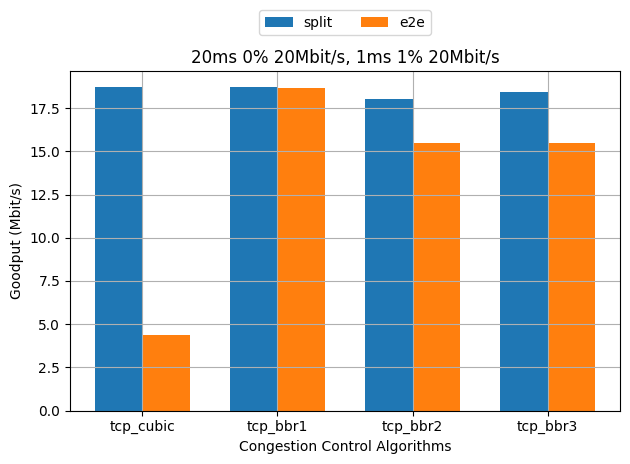

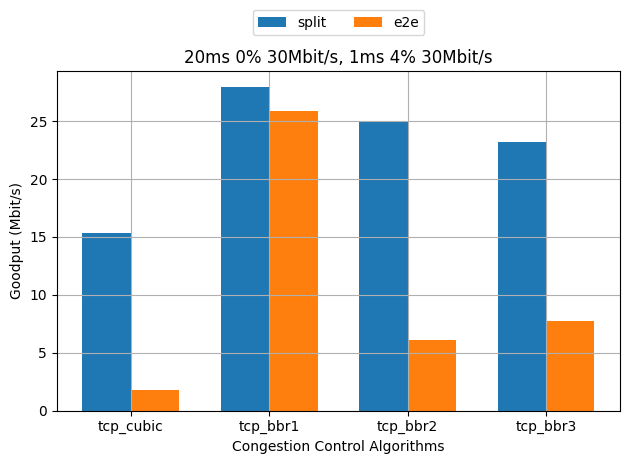

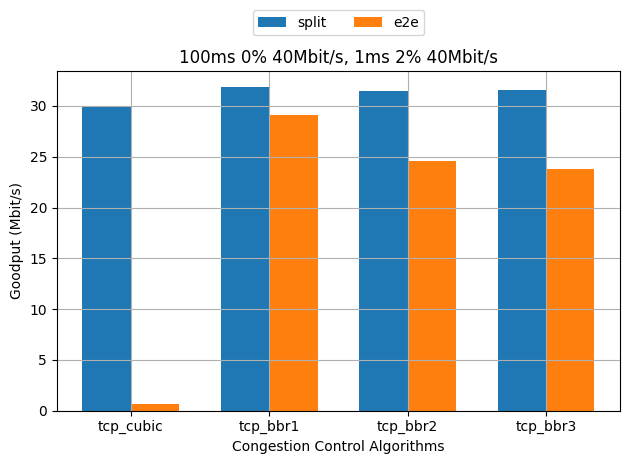

...


In [92]:
treatment = TCP_CUBIC

# Get initial results
results = get_initial_results(data, network_settings)

# Filter by required result trend criteria
results = filter_by(results, lambda x: True)
results = filter_by(results, lambda x: x.split_ratio(treatment) > 0.5, 'split performance achieves good ratio of botttleneck bw')
results = filter_by(results, lambda x: x.split_improvement_mul(treatment) > 1, 'split performance is at least 3x better than e2e performance')
results = filter_by(results, lambda x: x.e2e_goodput(treatment) > 0, 'e2e performance is nonzero')

# Filter by network split type
results = filter_by(results, lambda x: x.split_type() == SplitType.ASYMMETRIC_NEAR, 'asymmetric split type with the bottleneck on the near path segment')
# results = filter_by(results, lambda x: x.split_type() == SplitType.ASYMMETRIC_FAR, 'asymmetric split type with the bottleneck on the far path segment')

# Show results
show_random_results(results)

### BBRv1

There are no network settings where split performance is at least 2x (or even 50%) better than e2e performance for BBRv1.

In [93]:
treatment = TCP_BBRV1

# Get initial results
results = get_initial_results(data, network_settings)

# Filter by required result trend criteria
results = filter_by(results, lambda x: True)
results = filter_by(results, lambda x: x.split_ratio(treatment) > 0.5, 'split performance achieves good ratio of botttleneck bw')
results = filter_by(results, lambda x: x.split_improvement_mul(treatment) > 0.5, 'split performance is at least 50% better than e2e performance')

# Show results
show_random_results(results)

1575 
1575 split performance achieves good ratio of botttleneck bw
0 split performance is at least 50% better than e2e performance
...


### BBRv3

Network types for which BBRv3 has a large improvement in split performance over e2e performance, and in which e2e performance achieves a good ratio of the bottleneck bandwidth, fall into the same ASYMMETRIC_NEAR or ASYMMETRIC_FAR categories as CUBIC. BUT BBRv3 actually achieves good (at least 3x better than e2e) split goodput for many network settings in which there is loss on both path segments, including those for which the delay is more symmetric.

1575 
1339 split performance achieves good ratio of botttleneck bw
60 split performance is at least 3x better than e2e performance
60 e2e performance is nonzero
46 network type is the NEW kind where both path segments are lossy


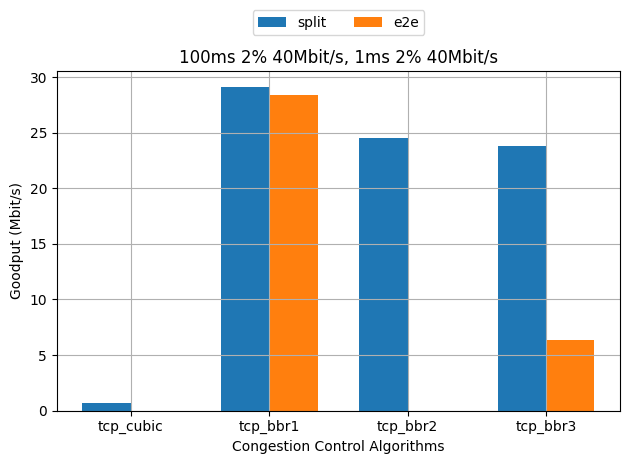

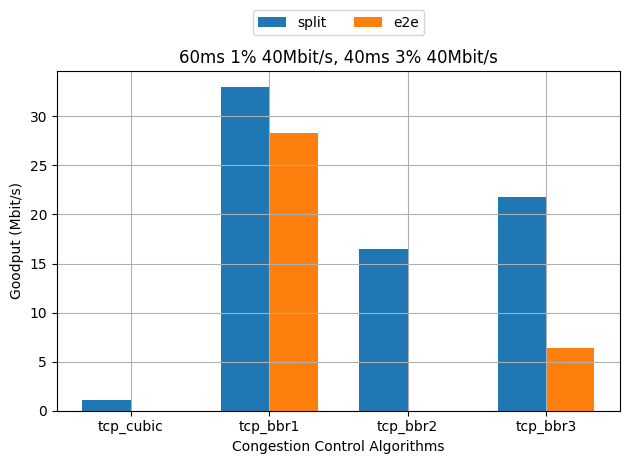

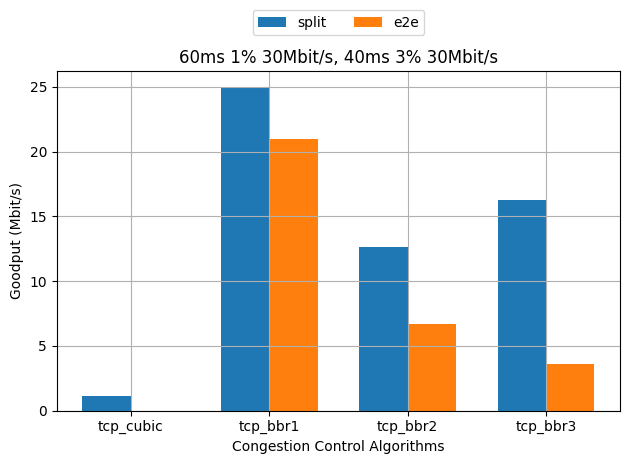

...


In [94]:
treatment = TCP_BBRV3

# Get initial results
results = get_initial_results(data, network_settings)

# Filter by required result trend criteria
results = filter_by(results, lambda x: True)
results = filter_by(results, lambda x: x.split_ratio(treatment) > 0.5, 'split performance achieves good ratio of botttleneck bw')
results = filter_by(results, lambda x: x.split_improvement_mul(treatment) > 2, 'split performance is at least 3x better than e2e performance')
results = filter_by(results, lambda x: x.e2e_goodput(treatment) > 0, 'e2e performance is nonzero')

# Filter by network split type
# results = filter_by(results, lambda x: x.split_type() in [SplitType.ASYMMETRIC_NEAR, SplitType.ASYMMETRIC_FAR], 'network type is the common asymmetric kind')
results = filter_by(results, lambda x: x.split_type() == SplitType.BOTH_LOSSY, 'network type is the NEW kind where both path segments are lossy')

# Show results
show_random_results(results)

## Find marquee network settings

### Asymmetric type - both CUBIC and BBRv3 benefit

1575 
100 network type is the common asymmetric kind
100 bbrv3 split performance achieves good ratio of botttleneck bw
20 bbrv3 split performance is at least 2x better than e2e performance
20 bbrv3 e2e performance is nonzero
10 cubic split performance achieves good ratio of botttleneck bw
10 cubic split performance is at least 2x better than e2e performance
5 delay1 == 100
1 bw1 == bw2 == 20


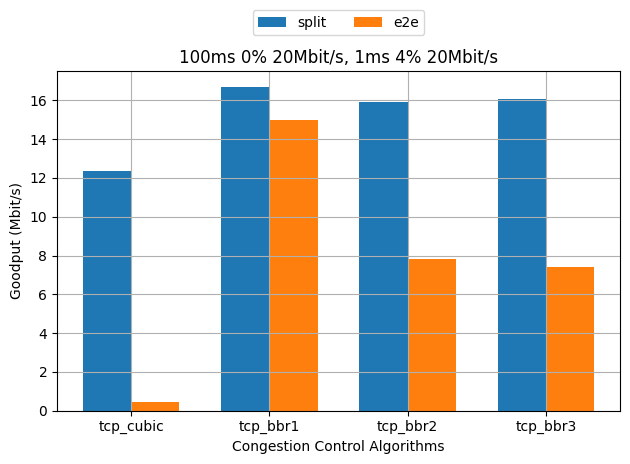

...


In [118]:
# Get initial results
results = get_initial_results(data, network_settings)

# Filter by network split type
results = filter_by(results, lambda x: True)
results = filter_by(results, lambda x: x.split_type() == SplitType.ASYMMETRIC_NEAR, 'network type is the common asymmetric kind')
# results = filter_by(results, lambda x: x.split_type() == SplitType.ASYMMETRIC_FAR, 'network type is the common asymmetric kind')

# Filter by baseline split to e2e performance
# For BBRv3
results = filter_by(results, lambda x: x.split_ratio(TCP_BBRV3) > 0.5, 'bbrv3 split performance achieves good ratio of botttleneck bw')
results = filter_by(results, lambda x: x.split_improvement_mul(TCP_BBRV3) > 1, 'bbrv3 split performance is at least 2x better than e2e performance')
results = filter_by(results, lambda x: x.e2e_goodput(TCP_BBRV3) > 0, 'bbrv3 e2e performance is nonzero')
# For CUBIC
results = filter_by(results, lambda x: x.split_ratio(TCP_CUBIC) > 0.5, 'cubic split performance achieves good ratio of botttleneck bw')
results = filter_by(results, lambda x: x.split_improvement_mul(TCP_CUBIC) > 1, 'cubic split performance is at least 2x better than e2e performance')
# results = filter_by(results, lambda x: x.e2e_goodput(TCP_CUBIC) > 0, 'cubic e2e performance is nonzero')

# Filter remaining graphs
results = filter_by(results, lambda x: x.s1.delay == 100, 'delay1 == 100')
results = filter_by(results, lambda x: x.s1.bw == 20, 'bw1 == bw2 == 20')
# results = filter_by(results, lambda x: x.s2.loss == 3, 'bbrv2 trends downwards')

# Show results
show_random_results(results, n=10)

### Both lossy type - only BBRv3 benefits

1575 
630 network type is the NEW kind where both path segments are lossy
564 bbrv3 split performance achieves good ratio of botttleneck bw
132 bbrv3 split performance is at least 2x better than e2e performance
132 bbrv3 e2e performance is nonzero
45 bbrv3 split performance is better
1 symmetric delays
1 symmetric losses


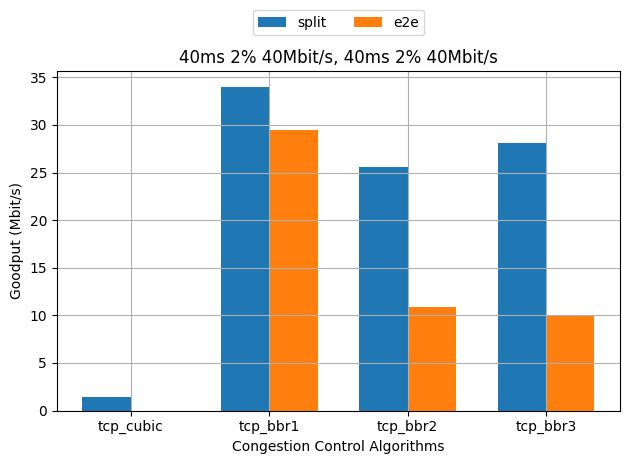

...


In [123]:
# Get initial results
results = get_initial_results(data, network_settings)

# Filter by network split type
results = filter_by(results, lambda x: True)
results = filter_by(results, lambda x: x.split_type() == SplitType.BOTH_LOSSY, 'network type is the NEW kind where both path segments are lossy')

# Filter by baseline split to e2e performance
# For BBRv3
results = filter_by(results, lambda x: x.split_ratio(TCP_BBRV3) > 0.5, 'bbrv3 split performance achieves good ratio of botttleneck bw')
results = filter_by(results, lambda x: x.split_improvement_mul(TCP_BBRV3) > 1, 'bbrv3 split performance is at least 2x better than e2e performance')
results = filter_by(results, lambda x: x.e2e_goodput(TCP_BBRV3) > 0, 'bbrv3 e2e performance is nonzero')
# For CUBIC
# results = filter_by(results, lambda x: x.split_ratio(TCP_CUBIC) < 0.5, 'cubic split performance achieves poor ratio of botttleneck bw')
# results = filter_by(results, lambda x: x.e2e_goodput(TCP_CUBIC) > 0, 'cubic e2e performance is nonzero')

# Filter remaining graphs
results = filter_by(results, lambda x: x.split_ratio(TCP_BBRV3) > 0.7, 'bbrv3 split performance is better')
results = filter_by(results, lambda x: x.s1.delay == x.s2.delay, 'symmetric delays')
results = filter_by(results, lambda x: x.s1.loss == x.s2.loss, 'symmetric losses')

# Show results
show_random_results(results)

# Summarize interesting network settings

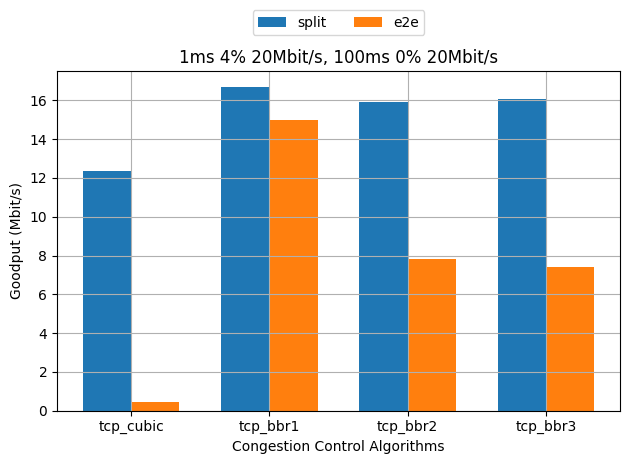

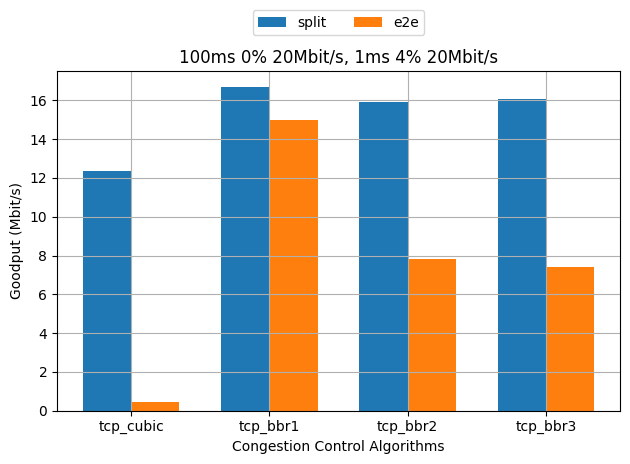

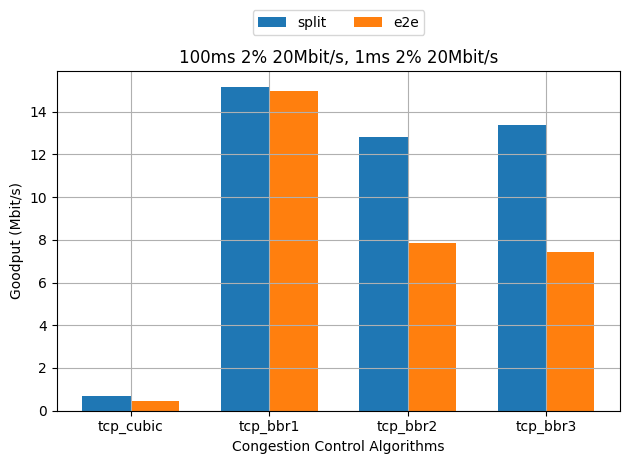

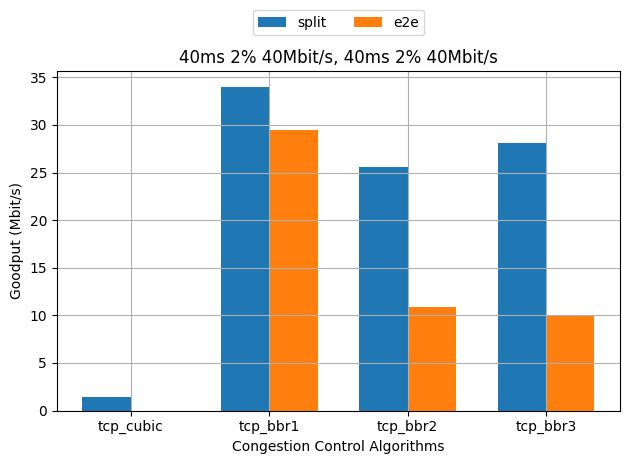

...


In [126]:
interesting_nses = [
    # delay, loss, bw
    (NetworkModel(100, 0, 20), NetworkModel(1, 4, 20)),  # ASYMMETRIC_NEAR
    (NetworkModel(1, 4, 20), NetworkModel(100, 0, 20)),  # ASYMMETRIC_FAR
    (NetworkModel(100, 2, 20), NetworkModel(1, 2, 20)),  # ASYMMETRIC_BOTH_LOSSY
    (NetworkModel(40, 2, 40), NetworkModel(40, 2, 40)),  # SYMMETRIC_BOTH_LOSSY
]

show_random_results(get_initial_results(data, interesting_nses), n=len(interesting_nses))

Note the network settings down here without needing to re-analyze theoretical data that may not be on this machine.

* We aim to test releases of BBRv1 dating back to 2016.
* In **TCPBenchmark**, the Python code keeps the `<cca>` as is and sets the Linux 
  congestion control module `sysctl -w net.ipv4.tcp_congestion_control=<cca>`.
* This notebook is only for plotting data. Execute the data on each Linux kernel
  and aggregate the data separately.

<!-- Not in use:
* In **QUICBenchmark**, the Python code converts the `<cca>` into an `<option>`
such as `TBBR-20240101`. The Chromium QUIC code receives this option via
`--client_connection_options=<option>` and `--connection_options=<option>`.
_We should pre-compile congestion control files linked to these options
in the Chromium QUIC code._
* These may be challenging, depending on how consistent the interfaces
between Linux kernel congestion control modules and TCP, and
Chromium QUIC congestion control modules and the newest toy client
and server, are over time.
* In the TCP benchmark, we can add another layer in the Python code from the
date to the actual module, similar to what exists in the QUIC benchmark. -->

In [10]:
# Generate the treatments
treatments_map = {
    'pep': [PEP_CUBIC, PEP_BBRV1, PEP_BBRV2, PEP_BBRV3],
    'tcp': [TCP_CUBIC, TCP_BBRV1, TCP_BBRV2, TCP_BBRV3],
}

In [11]:
# Generate a representative network setting and data size
num_trials = 10
network_settings = [
    NetworkSetting(delay1=1, delay2=20, loss1='4', loss2='0', bw1=30, bw2=30),
    NetworkSetting(delay1=1, delay2=20, loss1='4', loss2='0', bw1=30, bw2=30).mirror(),
    NetworkSetting(delay1=20, delay2=20, loss1='2', loss2='2', bw1=50, bw2=50),
    NetworkSetting(delay1=1, delay2=20, loss1='3', loss2='1', bw1=30, bw2=30),
]
data_size = lambda bw: int(10*1000000*bw/8)  # 10x the bottleneck bandwidth
data_sizes = [data_size(min(ns.get('bw1'), ns.get('bw2'))) for ns in network_settings]

For a given index, execute the TCP and PEP experiment on this machine.
The script automatically writes the data to the correct subdirectory in `data/`.
To aggregate all the data, we can `rsync` each the `data/` directory from each server
with the `data/` directory on a central machine. Then execute the remainder of the
Jupyter notebook to plot the data together.

In [12]:
# TODO: Set the index for the appropriate kernel!
index = 1

In [13]:
# Define the experiment
exp = Experiment(
    num_trials=1,
    treatments=[treatments_map['tcp'][index], treatments_map['pep'][index]],
    network_settings=network_settings,
    data_sizes=data_sizes,
    cartesian=False,
)

# Parse data
execute = True
raw_data = RawData(exp, execute=execute)

In [14]:
# TODO: Set the index for the appropriate kernel!
index = 1

In [15]:
def network_settings_with_qdisc(network_settings, qdisc):
    ns_qdiscs = []
    for ns in network_settings:
        ns_qdisc = ns.clone()
        ns_qdisc.set('qdisc', qdisc)
        ns_qdiscs.append(ns_qdisc)
    return ns_qdiscs

def network_setting_with_qdiscs(network_setting, qdiscs):
    ns_qdiscs = []
    for qdisc in qdiscs:
        ns_qdisc = network_setting.clone()
        ns_qdisc.set('qdisc', qdisc)
        ns_qdiscs.append(ns_qdisc)
    return ns_qdiscs

In [12]:
qdiscs = [
    'red',
    'bfifo-large',
    'bfifo-small',
    'pie',
    'policer',
    # 'codel',
]
for qdisc in qdiscs:
    # Define the experiment
    exp = Experiment(
        num_trials=50,
        treatments=[
            treatments_map['pep'][index],
            treatments_map['tcp'][index],
        ],
        network_settings=network_settings_with_qdisc(network_settings, qdisc),
        data_sizes=data_sizes,
        cartesian=False,
    )

    # Parse data
    execute = True
    raw_data = RawData(exp, execute=execute)

In [16]:
def plot_bbr_over_time(data, groups, treatments_map, delta=40, ylabel='Goodput (Mbit/s)'):
    assert len(data.network_settings) == 1
    network = data.network_settings[0]
    assert len(data.data_sizes) == 1
    data_size = data.data_sizes[0]

    # Bar width and positions
    bar_width = 0.35
    x = np.arange(len(groups))  # group positions
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Add bars for each treatment
    for i, (label, cca_treatments) in enumerate(treatments_map.items()):
        ys = []
        yerr_lower = []
        yerr_upper = []

        for cca_treatment in cca_treatments:
            sublabel = cca_treatment.label()
            subdata = data.data[sublabel][network].get(data_size)
            if subdata is None:
                ys.append(0)
                yerr_lower.append(0)
                yerr_upper.append(0)
                continue
            ys.append(subdata.p(50))
            yerr_lower.append(subdata.p(50) - subdata.p(50-delta))
            yerr_upper.append(subdata.p(50+delta) - subdata.p(50))
        
        tcp_bars = ax.bar(x - bar_width/2 + i * bar_width, ys, bar_width, yerr=(yerr_lower, yerr_upper), label=label)
        
    # Labeling and formatting
    ax.set_xlabel('Congestion Control Algorithms')
    ax.set_ylabel(ylabel)
    ax.set_title(network)
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.grid()
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 -t 9 --label tcp_bbr1 tcp -cca bbr -n 37500000


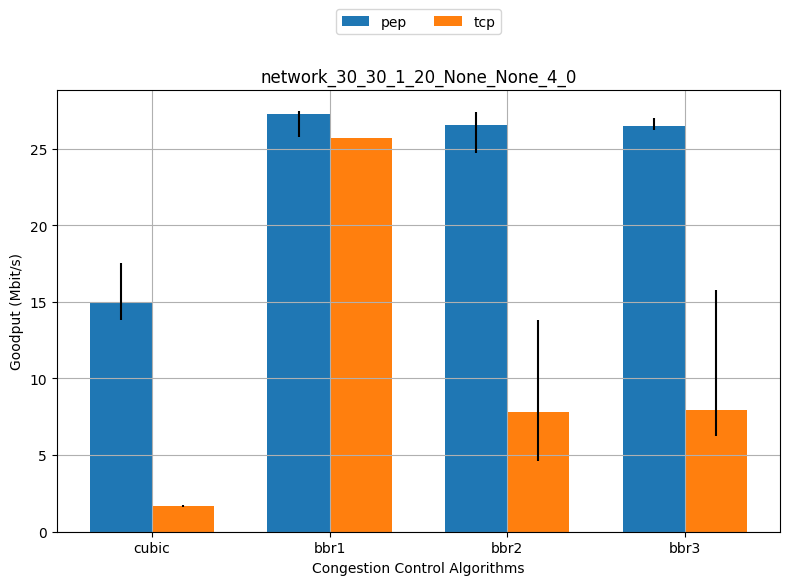

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 -t 9 --label tcp_bbr1 tcp -cca bbr -n 37500000


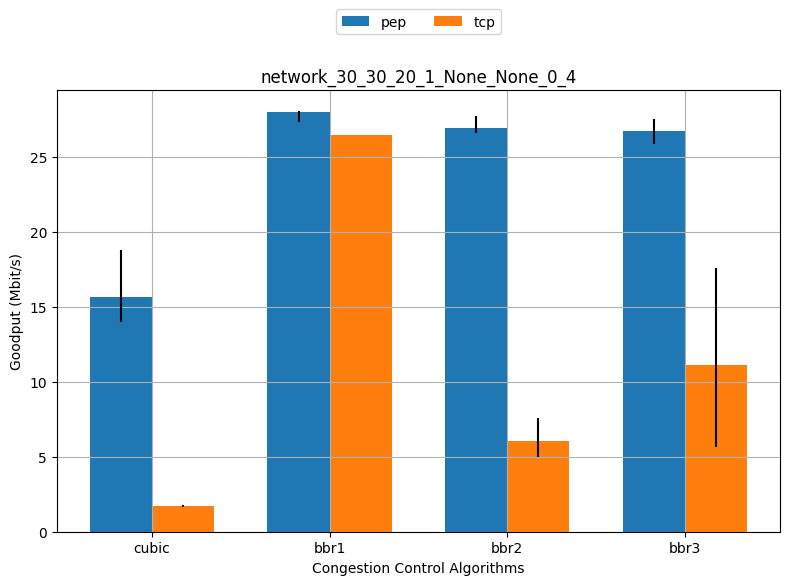

MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 -t 9 --label tcp_bbr1 tcp -cca bbr -n 62500000


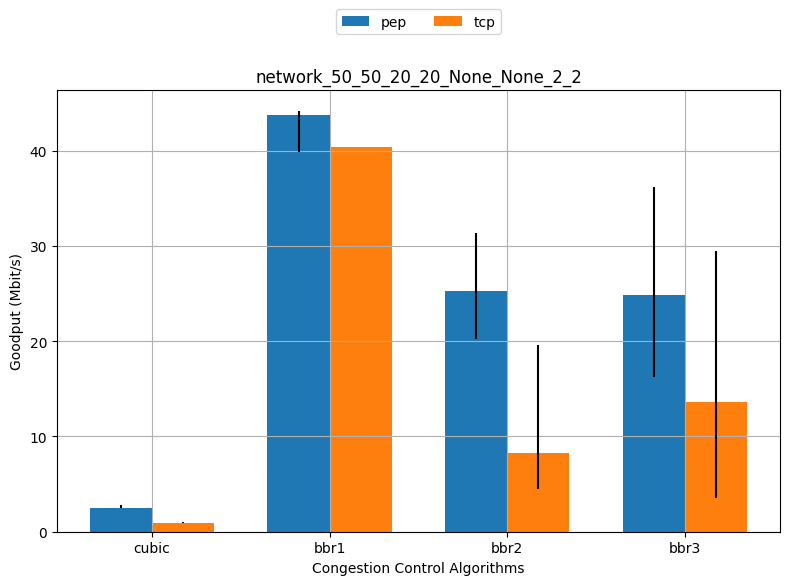

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 -t 9 --label tcp_bbr1 tcp -cca bbr -n 37500000


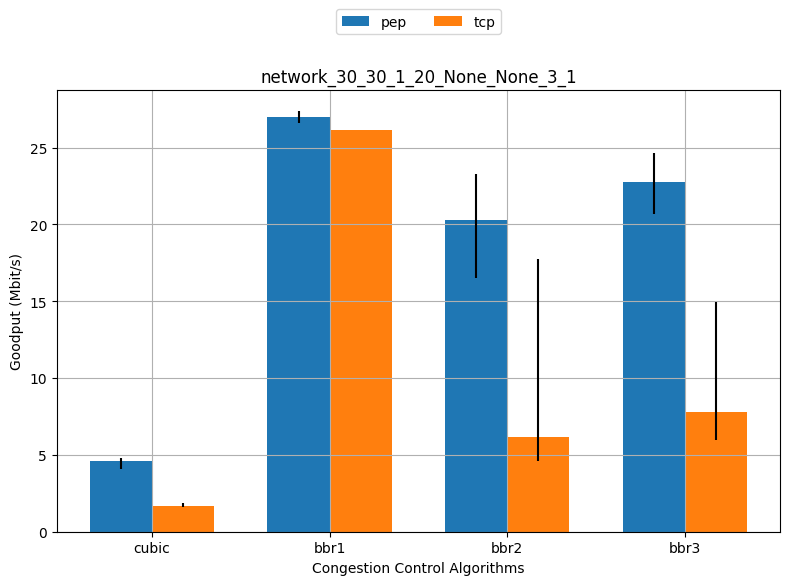

In [17]:
# Define the experiment
for network_setting, data_size in zip(network_settings, data_sizes):
    exp = Experiment(
        num_trials=num_trials,
        treatments=sum(treatments_map.values(), []),
        network_settings=[network_setting],
        data_sizes=[data_size],
    )
    
    # Parse data
    raw_data = RawData(exp, execute=False)
    
    # Convert to plottable data
    metric = 'throughput_mbps'
    plottable_data = PlottableData(raw_data, metric=metric)
    plot_bbr_over_time(plottable_data, GROUPS, treatments_map)